# Open cluster cataloging
##### In this notebook we study the discrepancies between various (open) cluster catalogues. We use the open cluster catalogue by Hunt & Reffert (2023) as reference cluster and we base our results under the assumptions that the catalogue concerned, achieved the most accurate and precise data for the open clusters in question.

First we start by creating a datahandler made to get tables from the catalogues in question. We crossmatch the literature with the crossmatch table by Hunt & Reffert (2023). We then see if any of those crossmatched clusters occur in the original literature data. The clusters in the literature can be in one of two states which yields respective data tables:
- Matched = The clusters from the literature is confirmed by the Hunt-catalogue
  - Out of $N$ literature clusters $C$ Hunt-clusters are confirmed which yields $C$ records in the literature-and Hunt-catalogue (I and II in the code)
- Not Matched = The clusters from the literature is not confirmed
  - Out of $N$ literature clusters $N-C$ literature clusters are refuted which yields $N-C$ records in the literature catalogue (III in the code) 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
plt.style.use('Solarize_Light2')

mpl.rcParams['figure.dpi'] = 150

cantat = pd.read_csv('Data\\CantatGaudin\\cantatgaudinfile.csv')
hunt = pd.read_csv('Data\\Hunt\\huntfile.csv')
xmatch = pd.read_csv('Data\\Hunt\\xmatchfile.csv').dropna(subset=['Sep'])
khar = pd.read_csv('Data\\Kharchenko\\kharchenkofile.csv').query('Type != "g"')
dias = pd.read_csv('Data\\Dias\\diasfile.csv')
dias['Cluster'] = dias['Cluster'].str.replace(' ', '_').str.replace('-', '_')

In [2]:
def datahandler(df_lit, df=hunt, crossmatch=xmatch):

    if df_lit is cantat: # Define the source catalog and the column name of the cluster name, each table has different names for the cluster name column
        sourcecat = 'Cantat-Gaudin+20'
        NameCol = 'Cluster'
    elif df_lit is khar:
        sourcecat = 'Kharchenko+13'
        NameCol = 'Name'
    elif df_lit is dias:
        sourcecat = 'Dias+02'
        NameCol = 'Cluster'

    df = df.query('Type == "o"') #Only open clusters
    crossmatch = crossmatch.query('SourceCat == @sourcecat').drop_duplicates('ID')

    xm = pd.merge(crossmatch, df, on='ID', how='inner') #Crossmatched clusters
    allnames = xm.assign(synonym = xm['AllNames'].str.split(',')).explode('synonym').add_suffix('_h') #Create AllNames column with synonyms of the OCs
    
    df_matched = pd.merge(df_lit, allnames, left_on=NameCol, right_on='synonym_h', how='outer', indicator=True).drop_duplicates(NameCol) #Crossmatched clusters (matched with literature)
    
    matched = df_matched.query('_merge == "both"') #Matched clusters
    not_matched = df_matched.query('_merge == "left_only"') #Not matched clusters
    
    hunt_matched = matched.filter(regex='_h$').drop(columns=['synonym_h']) # Matched clusters in Hunt (I)
    lit_matched = matched[df_lit.columns] # Matched clusters in literature (II)
    lit_not_matched = not_matched[df_lit.columns] # Not matched clusters in literature (III)
    
    return hunt_matched, lit_matched, lit_not_matched


#function to change column to numpy array and plot

def DFplot(df, col1, col2=None):
 
    if col2 is None:
            values = df[col1]
            if values.dtype == 'object':
                 values.value_counts(sort=False).plot(kind='bar')
                 plt.xlabel(col1)
                 plt.ylabel('counts')
                 plt.title(f'Histogram of {col1}')
                 plt.grid(True)
                 plt.savefig(f'./Data/PlotKharchenko/Hist/{col1}.png', format='png', bbox_inches='tight')
                 plt.show()

            else:
                plt.hist(values, bins=20)
                plt.xlabel(col1)
                plt.ylabel('counts')
                plt.title(f'Histogram of {col1}')
                plt.grid(True)
                plt.savefig(f'./Data/PlotKharchenko/Hist/{col1}.png', format='png', bbox_inches='tight')
                plt.show()
    else:
            # Extracting columns for scatter plot
        x_values = df[col1]
        y_values = df[col2]
        if x_values.dtype == 'object':
            print(f'{x_values} is a string')
            pass
        elif y_values.dtype == 'object':
            print(f'{y_values} is a string')
            pass
        else:
            plt.scatter(x_values, y_values, s=2)
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.title(f'Scatter Plot of {col1} vs {col2}')
            plt.grid(True)
            plt.savefig(f'./Data/PlotKharchenko/Scatter/{col1}vs{col2}.png', format='png', bbox_inches='tight')
            plt.show()


In [3]:
cantat_matched, cantat_lit, cantat_not_matched = datahandler(cantat)
khar_matched, khar_lit, khar_not_matched = datahandler(khar)
dias_matched, dias_lit, dias_not_matched = datahandler(dias)

print(f'Cantat matched: {cantat_matched.shape[0]}, Cantat not matched: {cantat_not_matched.shape[0]}, Cantat total: {cantat.shape[0]}')
print(f'Kharchenko matched: {khar_matched.shape[0]}, Kharchenko not matched: {khar_not_matched.shape[0]}, Kharchenko total: {khar.shape[0]}')
print(f'Dias matched: {dias_matched.shape[0]}, Dias not matched: {dias_not_matched.shape[0]}, Dias total: {dias.shape[0]}')
print('These numbers are different from the numbers in the paper of Hunt & Reffert (2023), which is a result of the different crossmatch method used in this work.')


Cantat matched: 1427, Cantat not matched: 54, Cantat total: 1481
Kharchenko matched: 1391, Kharchenko not matched: 1468, Kharchenko total: 2859
Dias matched: 1167, Dias not matched: 999, Dias total: 2167
These numbers are different from the numbers in the paper of Hunt & Reffert (2023), which is a result of the different crossmatch method used in this work.


## Analyzation
Now that we have the relevant tables containing the cluster properties, we can proceed with further analysis to understand why some clusters appear in the literature but not in the current standard (Gaia DR3). Our next avenues of analysis include:

- Correlation matrices: We will explore the relationships between different properties of the clusters, such as their positions, sizes, and kinematic parameters. This will help us identify any correlations or dependencies among these variables.

- Minimum spanning tree/hierarchical clustering: By applying these techniques, we can identify clusters that are closely related based on their properties. This will allow us to group clusters with similar characteristics and potentially discover any underlying structures or subgroups.

- Binary classification: We will develop a classification model to predict whether a cluster belongs to the literature or the current standard based on its properties. This will help us understand the key features that differentiate these two groups and potentially uncover any biases or discrepancies between them.

By conducting these analyses, we aim to gain insights into the reasons behind the differences between clusters mentioned in the literature and those identified in Gaia DR3.

,ID_h,NameLit_h,SourceCat_h,TypeSourceCat_h,Sep_h,SepTidal_h,SepTidalLit_h,SepTidalData_h,pmRASep_h,pmRASigma_h,...,diffAV50_h,diffAV84_h,MOD16_h,MOD50_h,MOD84_h,minClSize_h,isMerged_h,isGMMMemb_h,NXmatches_h,XmatchType_h
0,231.0,Berkeley_58,Kharchenko+13,position,0.006830,0.041804,0.044066,0.041804,NaN,NaN,...,1.038912,1.334916,12.264112,12.427092,12.574502,80.0,0.0,0.0,1.0,m:1
3,5372.0,Stock_18,Kharchenko+13,position,0.003288,0.034777,0.041102,0.034777,NaN,NaN,...,1.764751,2.259569,12.086885,12.269488,12.445960,40.0,0.0,0.0,1.0,1:1
4,232.0,Berkeley_59,Kharchenko+13,hipparcos,0.005466,0.004679,0.024846,0.004679,1.5900,0.412741,...,3.008986,3.387702,9.851921,10.049288,10.215112,20.0,0.0,0.0,2.0,1:m
6,281.0,Blanco_1,Kharchenko+13,hipparcos,0.028050,0.011937,0.011937,0.015237,0.9855,0.301859,...,0.404469,0.638031,6.719911,6.870345,7.018337,20.0,0.0,0.0,1.0,1:1
7,275.0,Berkeley_104,Kharchenko+13,hipparcos,0.010430,0.057818,0.077225,0.057818,2.1910,0.546044,...,1.550098,1.976313,13.020064,13.150587,13.345947,40.0,0.0,0.0,1.0,1:1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,4869.0,NGC_7788,Kharchenko+13,hipparcos,0.004895,0.030359,0.040794,0.030359,3.2860,0.691473,...,0.371733,0.538566,12.066921,12.258471,12.414864,80.0,0.0,0.0,1.0,1:1
2974,4870.0,NGC_7789,Kharchenko+13,hipparcos,0.015770,0.029368,0.037990,0.029368,1.5340,0.533257,...,0.255012,0.384448,11.292359,11.465099,11.606305,80.0,0.0,0.0,3.0,m:m
2977,4871.0,NGC_7790,Kharchenko+13,position,0.015520,0.100686,0.107046,0.100686,NaN,NaN,...,0.681711,0.931829,12.436250,12.605278,12.754203,80.0,0.0,0.0,2.0,1:m
2979,1532.0,FSR_0460,Kharchenko+13,hipparcos,0.005924,0.029156,0.069696,0.029156,3.0610,0.761693,...,1.613134,2.047945,13.472683,13.624321,13.798079,80.0,0.0,0.0,1.0,1:1


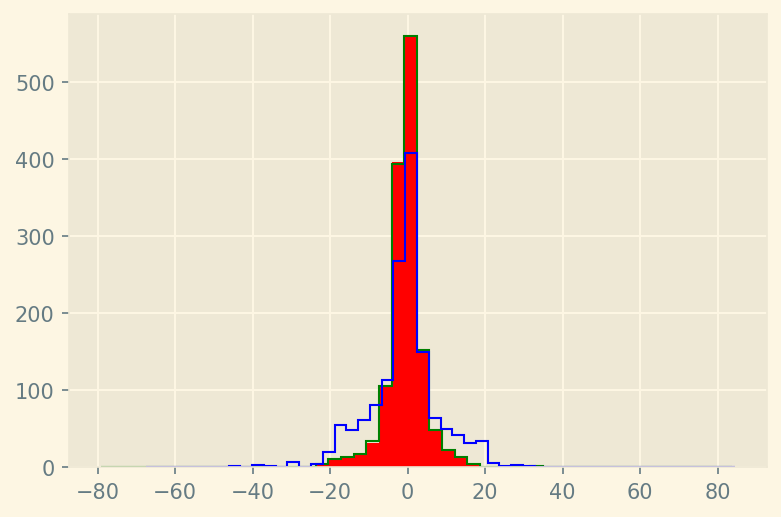

In [5]:
plt.hist(khar_matched['GLAT_h'], bins=50, histtype='stepfilled', color='r')
plt.hist(khar_lit['GLAT'], bins=50, histtype='step', color='g')
plt.hist(khar_not_matched['GLAT'], bins=50, histtype='step', color='b')
plt.show()



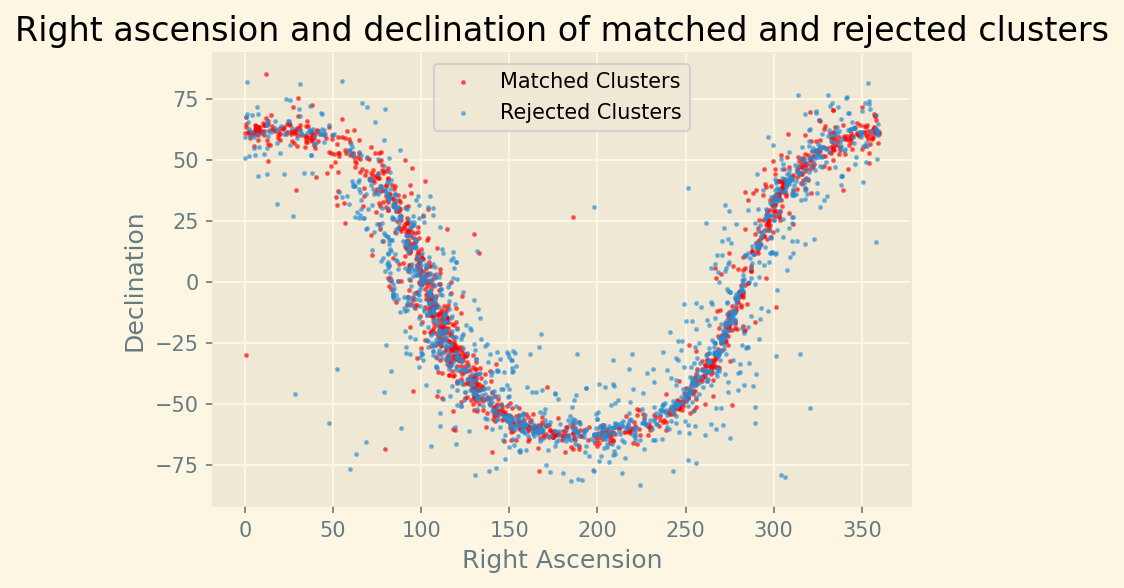

In [6]:
#right ascension and declination. No difference between matched and rejected. Though the matched clusters follow the trend a lot better
rahour = np.asarray(khar_not_matched['RAhour'])
rahour2 = np.asarray(khar_lit['RAhour'])*15
plt.scatter(khar_matched['RAdeg_h'], khar_matched['DEdeg_h'], s=2, c='r', label = 'Matched Clusters', alpha=0.5)
plt.scatter(rahour*15, khar_not_matched['DEdeg'], s=2, label='Rejected Clusters', alpha=0.5)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('Right ascension and declination of matched and rejected clusters')
plt.legend()
plt.show()


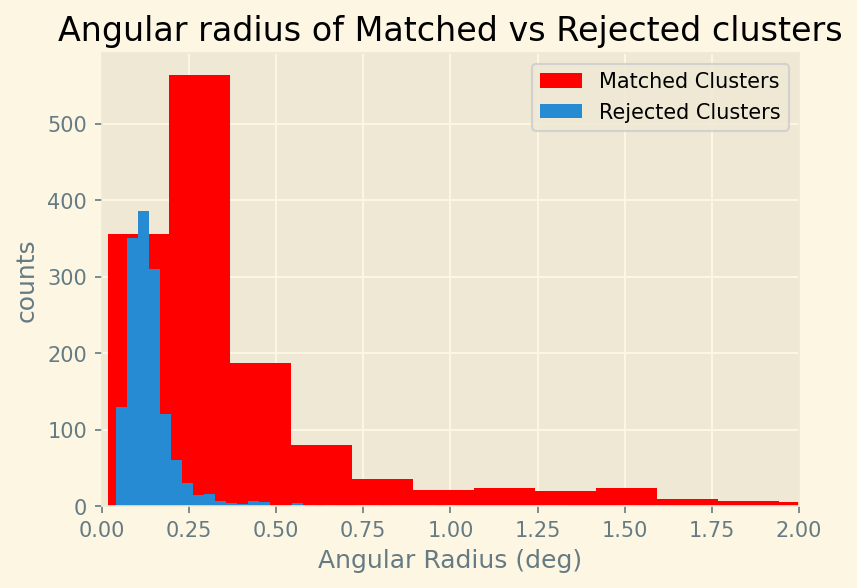

In [7]:
plt.hist(khar_matched['rt_h'], bins=100, color='r', label='Matched Clusters')
plt.hist(khar_not_matched['r2'], bins=100, label='Rejected Clusters')
plt.xlabel('Angular Radius (deg)')
plt.xlim(0, 2)
plt.ylabel('counts')
plt.title('Angular radius of Matched vs Rejected clusters')
plt.legend()
plt.show()

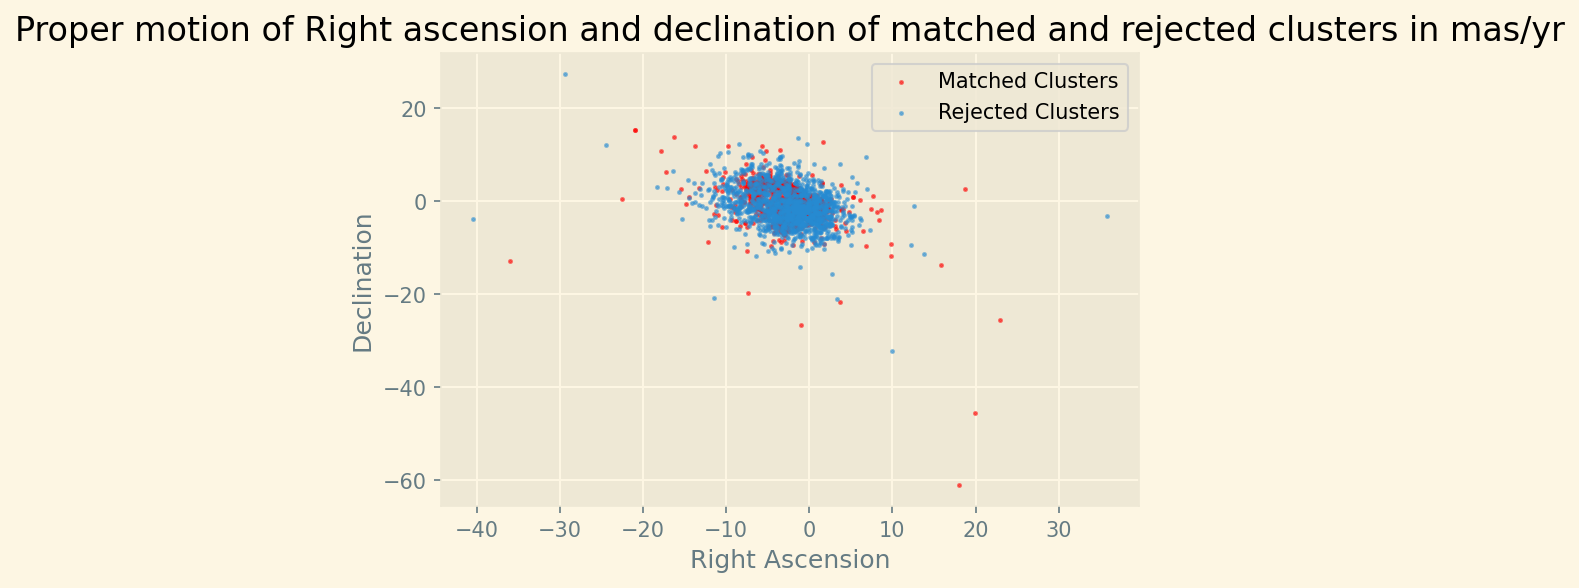

In [26]:
plt.scatter(khar_matched['pmRA_h'], khar_matched['pmDE_h'], s=2, c='r', label = 'Matched Clusters', alpha=0.5)
plt.scatter(khar_not_matched['pmRA'], khar_not_matched['pmDE'], s=2, label='Rejected Clusters', alpha=0.5)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('Proper motion of Right ascension and declination of matched and rejected clusters in mas/yr')
plt.legend()
plt.show()

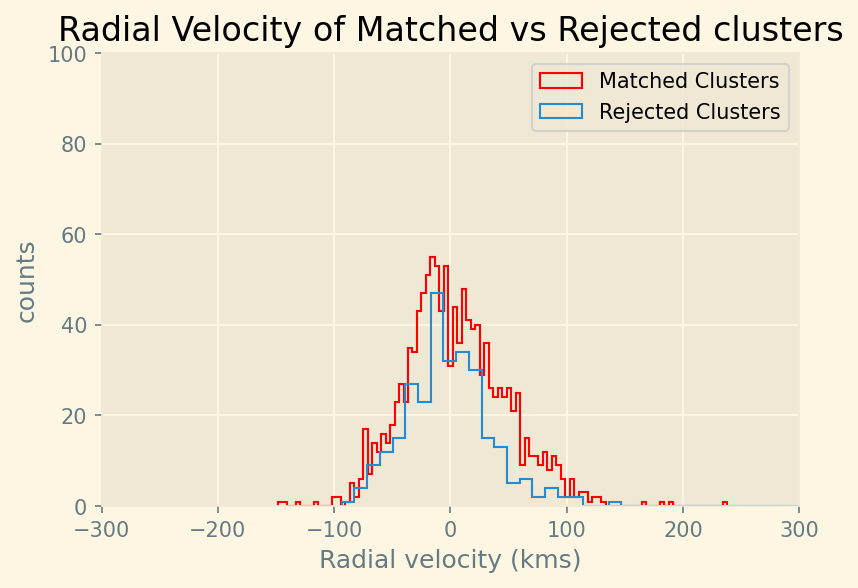

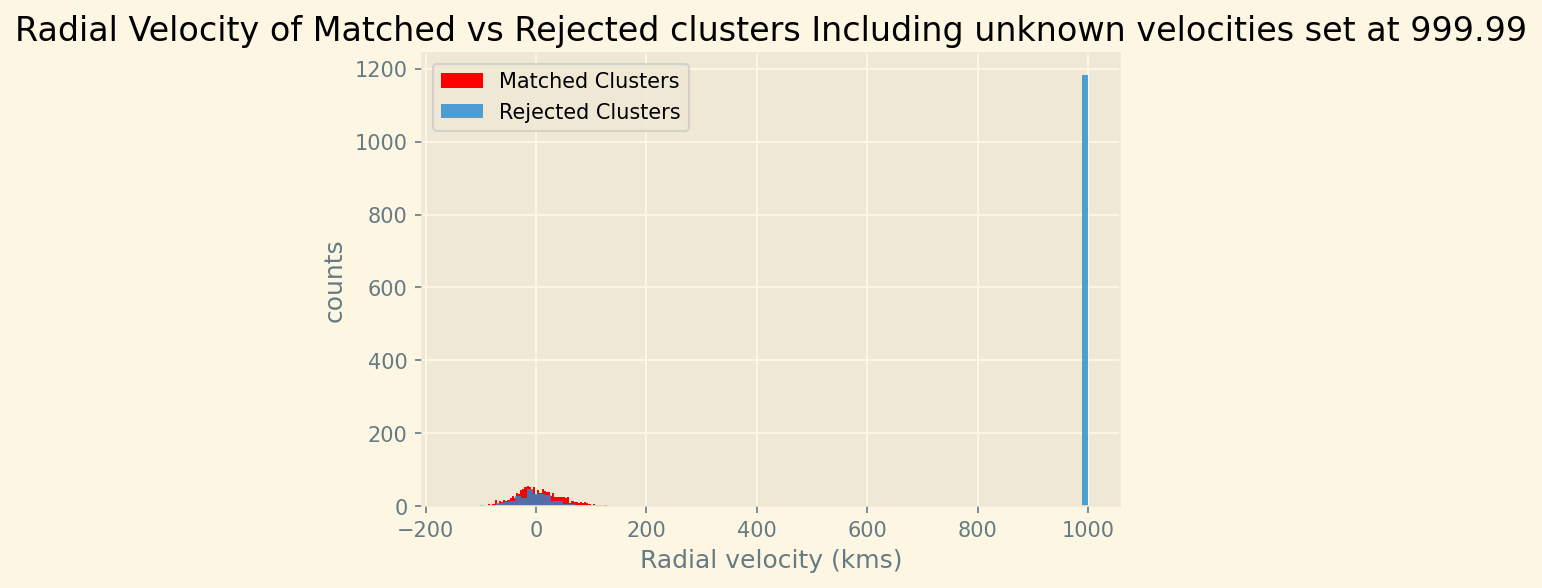

In [23]:
plt.hist(khar_matched['RV_h'], bins=100, color='r', label='Matched Clusters', histtype = 'step')
plt.hist(khar_not_matched['RV'], bins=100, label='Rejected Clusters', histtype='step')
plt.xlabel('Radial velocity (kms)')
plt.xlim(-300, 300)
plt.ylim(0, 100)
plt.ylabel('counts')
plt.title('Radial Velocity of Matched vs Rejected clusters')
plt.legend()
plt.show()

plt.hist(khar_matched['RV_h'], bins=100, color='r', label='Matched Clusters')
plt.hist(khar_not_matched['RV'], bins=100, label='Rejected Clusters', alpha =0.8)
plt.xlabel('Radial velocity (kms)')
plt.ylabel('counts')
plt.title('Radial Velocity of Matched vs Rejected clusters Including unknown velocities set at 999.99')
plt.legend()
plt.show()

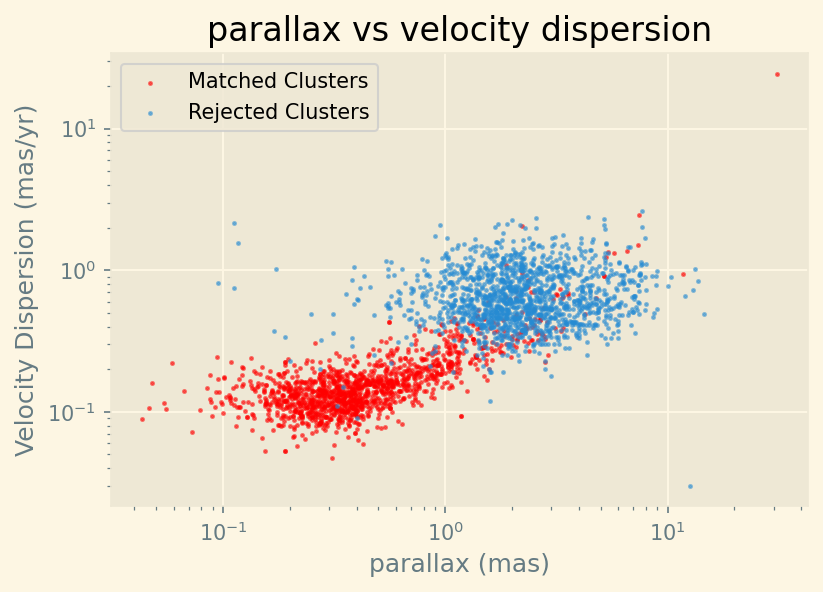

In [21]:
parfound = khar_matched['Plx_h']
parnotfound = khar_not_matched['d']/1000
veldisfound = np.sqrt(np.square(khar_matched['s_pmRA_h']) + np.square(khar_matched['s_pmDE_h']))
veldisnotfound = np.abs(khar_not_matched['e_pm'])

plt.scatter(parfound, veldisfound, s=2, c='r', label = 'Matched Clusters', alpha=0.5)
plt.scatter(parnotfound, veldisnotfound, s=2, label = 'Rejected Clusters', alpha=0.5)
plt.xlabel('parallax (mas)')
plt.ylabel('Velocity Dispersion (mas/yr)')
plt.title('parallax vs velocity dispersion')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()